## Atividade Curta 5 - LeNet

#### Aluno: 119891 - João Vitor Silva de Oliveira


### Imports

In [88]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

import copy
  
from datetime import datetime
from torchsummary import summary
import numpy as np


torch.manual_seed(42)
torch.cuda.manual_seed(42)


### Implementação LeNet

Foi adicionado o parâmetro `version` para a criação do modelo.
Quando for informado `Relu` será utilizado somente essa função de ativação, quando for informado outro valor será utilizado `Sigmoid + Tanh`

In [55]:
class LeNet(nn.Module) :
  
    def __init__(self, num_classes=10, n_channels=1, version='sigmoid_and_tanh'):
        super(LeNet, self).__init__()

        self.version = version
        if version == 'sigmoid_and_tanh':
            self.act1 = nn.Sigmoid()
            self.act2 = nn.Tanh()
        elif version == 'relu':
            self.act1 = nn.ReLU() 
            self.act2 = nn.ReLU() 
        
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5, padding=2, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=400, out_features=120)                  
        self.fc2 = nn.Linear(in_features=120, out_features=84)    
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)    
        
    def forward(self, x, debug=False):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool(x)
        
        # x = self.conv3(x)
        # x = self.act1(x)
       
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.act2(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        
        # x = torch.softmax(x, dim=1)
        # print(x.shape)

        return x

### Dataloaders

In [56]:
def get_data_cifar10(batch_size):
    transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5])
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/train', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10/test', train=False, download=True, transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, len(train_dataset.classes)

In [57]:
def get_data_mnist (batch_size) :
  
    train_dataset = torchvision.datasets.mnist.MNIST( root=f'./data/mnist/train/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.mnist.MNIST( root=f'./data/mnist/test/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    
    return trainloader, testloader, len(train_dataset.classes)

### Tensorboard

In [58]:
def plot_histograms_tensorboard(writer, net, epoch):
    writer.add_histogram('Bias/conv1',   net.conv1.bias,        epoch)
    writer.add_histogram('Weight/conv1', net.conv1.weight,      epoch)
    writer.add_histogram('Grad/conv1',   net.conv1.weight.grad, epoch)

    writer.add_histogram('Bias/conv2',   net.conv2.bias,        epoch)
    writer.add_histogram('Weight/conv2', net.conv2.weight,      epoch)
    writer.add_histogram('Grad/conv2',   net.conv2.weight.grad, epoch)

    writer.add_histogram('Bias/fc1',     net.fc1.bias,          epoch)
    writer.add_histogram('Weight/fc1',   net.fc1.weight,        epoch)
    writer.add_histogram('Grad/fc1',     net.fc1.weight.grad,   epoch)

    writer.add_histogram('Bias/fc2',     net.fc2.bias,          epoch)
    writer.add_histogram('Weight/fc2',   net.fc2.weight,        epoch)
    writer.add_histogram('Grad/fc2',     net.fc2.weight.grad,   epoch)

    writer.add_histogram('Bias/fc3',     net.fc3.bias,          epoch)
    writer.add_histogram('Weight/fc3',   net.fc3.weight,        epoch)
    writer.add_histogram('Grad/fc3',     net.fc3.weight.grad,   epoch)


### Validação

In [59]:
def validate ( model , data , device='cpu') :
    model.eval()
    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
    
    return correct*100./sum

### Treinamento

In [60]:
def train (model, train_loader, test_loader, batch_size, epochs=100, lr=1e-1, prefix='',
           upper_bound=99.0, device='cpu', save=False, debug=False, plot_histograms=False, lambda_reg=0) :

    optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay=lambda_reg)
    loss = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = prefix + '-' + suffix if prefix != '' else suffix

    writer = SummaryWriter( log_dir='./tensorboard/'+prefix )
    
    writer.add_graph(model, next(iter(train_loader))[0].to(device))

    accuracies = []
    max_accuracy = -1.0
    dataset_size = len(train_loader.dataset)


    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        model.train()  
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)


            optimizer.zero_grad()

            predict_y = model( train_x )

            # Loss:
            error = loss( predict_y , train_label.long() )

            writer.add_scalar( 'Loss/train', error, 
                            idx+( epoch*(dataset_size//batch_size) ) )

            error.backward()
            optimizer.step()

            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                            idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print(f'idx: {idx}, _error: {error}')

        if plot_histograms : 
            plot_histograms_tensorboard(writer, model, epoch)
        
        accuracy = validate(model, test_loader, device=device)
        accuracies.append(accuracy.cpu())
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
    
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = accuracy
            print(f'Saving Best Model with Accuracy: {max_accuracy:3.4f}')
            
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:3.4f}%' )

        if accuracy > upper_bound :
            break
   
    if save : 
        path = f'./LeNet5-{type(train_loader.dataset).__name__}-{max_accuracy:.2f}.pkl'
        torch.save(best_model.state_dict(), path)
        print('Model saved in:',path)
  
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model

## Execução

### Mnist (Sigmoid + Tanh)

Running on cuda.


Training epochs...:   5%|▌         | 1/20 [00:07<02:31,  7.98s/it]

Saving Best Model with Accuracy: 10.2800
Epoch:   1 | Accuracy : 10.2800%


Training epochs...:  10%|█         | 2/20 [00:16<02:24,  8.02s/it]

Saving Best Model with Accuracy: 87.2400
Epoch:   2 | Accuracy : 87.2400%


Training epochs...:  15%|█▌        | 3/20 [00:23<02:15,  7.97s/it]

Saving Best Model with Accuracy: 92.2600
Epoch:   3 | Accuracy : 92.2600%


Training epochs...:  20%|██        | 4/20 [00:31<02:06,  7.94s/it]

Saving Best Model with Accuracy: 94.3700
Epoch:   4 | Accuracy : 94.3700%


Training epochs...:  25%|██▌       | 5/20 [00:39<01:58,  7.92s/it]

Saving Best Model with Accuracy: 95.7000
Epoch:   5 | Accuracy : 95.7000%


Training epochs...:  30%|███       | 6/20 [00:47<01:50,  7.89s/it]

Saving Best Model with Accuracy: 96.2900
Epoch:   6 | Accuracy : 96.2900%


Training epochs...:  35%|███▌      | 7/20 [00:55<01:42,  7.90s/it]

Epoch:   7 | Accuracy : 95.9900%


Training epochs...:  40%|████      | 8/20 [01:03<01:34,  7.90s/it]

Saving Best Model with Accuracy: 96.9800
Epoch:   8 | Accuracy : 96.9800%


Training epochs...:  45%|████▌     | 9/20 [01:11<01:27,  7.95s/it]

Saving Best Model with Accuracy: 97.2300
Epoch:   9 | Accuracy : 97.2300%


Training epochs...:  50%|█████     | 10/20 [01:19<01:19,  7.99s/it]

Epoch:  10 | Accuracy : 96.7500%


Training epochs...:  55%|█████▌    | 11/20 [01:27<01:11,  7.95s/it]

Saving Best Model with Accuracy: 98.1100
Epoch:  11 | Accuracy : 98.1100%


Training epochs...:  60%|██████    | 12/20 [01:35<01:03,  7.91s/it]

Epoch:  12 | Accuracy : 97.9500%


Training epochs...:  65%|██████▌   | 13/20 [01:43<00:55,  7.90s/it]

Epoch:  13 | Accuracy : 98.0400%


Training epochs...:  70%|███████   | 14/20 [01:51<00:47,  7.92s/it]

Epoch:  14 | Accuracy : 97.8600%


Training epochs...:  75%|███████▌  | 15/20 [01:58<00:39,  7.92s/it]

Saving Best Model with Accuracy: 98.2900
Epoch:  15 | Accuracy : 98.2900%


Training epochs...:  80%|████████  | 16/20 [02:06<00:31,  7.89s/it]

Epoch:  16 | Accuracy : 97.8500%


Training epochs...:  85%|████████▌ | 17/20 [02:14<00:23,  7.91s/it]

Saving Best Model with Accuracy: 98.4700
Epoch:  17 | Accuracy : 98.4700%


Training epochs...:  90%|█████████ | 18/20 [02:22<00:15,  7.89s/it]

Epoch:  18 | Accuracy : 98.3600%


Training epochs...:  95%|█████████▌| 19/20 [02:30<00:07,  7.87s/it]

Epoch:  19 | Accuracy : 98.3800%


Training epochs...: 100%|██████████| 20/20 [02:38<00:00,  7.91s/it]

Epoch:  20 | Accuracy : 97.4600%
Model saved in: ./LeNet5-MNIST-98.47.pkl


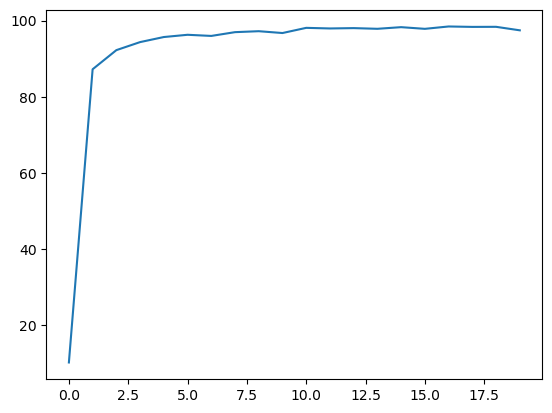

In [77]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Running on {device.type}.")

epochs = 20
lr = 0.1
lambda_reg = 0
batch_size = 64

train_loader, test_loader, num_classes = get_data_mnist(batch_size=batch_size)

model = LeNet(num_classes=num_classes, n_channels=1, version='sigmoid_and_tanh')

model = model.to(device)

prefix = 'MNIST-SigTanh-e-{}-lr-{}'.format(epochs, lr)

best_model = train(model, train_loader, test_loader, batch_size, epochs, lr, prefix, device=device, save=True, debug=False, plot_histograms=False, lambda_reg=lambda_reg)


### Mnist (Relu)

Training epochs...:   5%|▌         | 1/20 [00:07<02:31,  7.95s/it]

Saving Best Model with Accuracy: 95.1400
Epoch:   1 | Accuracy : 95.1400%


Training epochs...:  10%|█         | 2/20 [00:15<02:22,  7.94s/it]

Saving Best Model with Accuracy: 97.4700
Epoch:   2 | Accuracy : 97.4700%


Training epochs...:  15%|█▌        | 3/20 [00:23<02:15,  7.95s/it]

Saving Best Model with Accuracy: 98.2600
Epoch:   3 | Accuracy : 98.2600%


Training epochs...:  20%|██        | 4/20 [00:31<02:06,  7.92s/it]

Saving Best Model with Accuracy: 98.7200
Epoch:   4 | Accuracy : 98.7200%


Training epochs...:  25%|██▌       | 5/20 [00:39<01:58,  7.91s/it]

Saving Best Model with Accuracy: 98.8000
Epoch:   5 | Accuracy : 98.8000%


Training epochs...:  30%|███       | 6/20 [00:47<01:50,  7.90s/it]

Saving Best Model with Accuracy: 99.0000
Epoch:   6 | Accuracy : 99.0000%


Training epochs...:  35%|███▌      | 7/20 [00:55<01:43,  7.93s/it]

Epoch:   7 | Accuracy : 98.7200%


Training epochs...:  40%|████      | 8/20 [01:03<01:35,  7.97s/it]

Epoch:   8 | Accuracy : 98.7200%


Training epochs...:  45%|████▌     | 9/20 [01:11<01:27,  7.96s/it]

Epoch:   9 | Accuracy : 98.9900%


Training epochs...:  50%|█████     | 10/20 [01:19<01:19,  7.95s/it]

Epoch:  10 | Accuracy : 98.6300%


Training epochs...:  55%|█████▌    | 11/20 [01:27<01:11,  7.95s/it]

Epoch:  11 | Accuracy : 98.9400%


Training epochs...:  55%|█████▌    | 11/20 [01:35<01:17,  8.66s/it]

Saving Best Model with Accuracy: 99.0200
Epoch:  12 | Accuracy : 99.0200%
Model saved in: ./LeNet5-MNIST-99.02.pkl


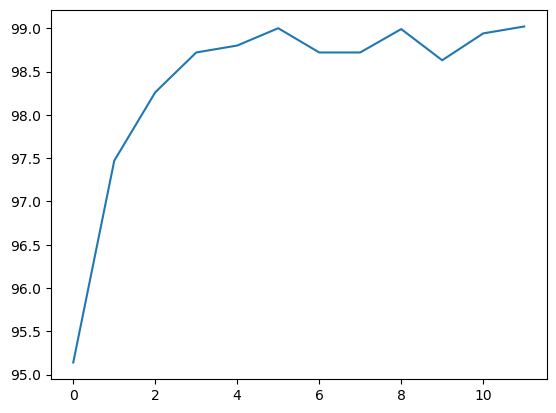

In [78]:
model = LeNet(num_classes=num_classes, n_channels=1, version='relu')

model = model.to(device)

prefix = 'MNIST-RELU-e-{}-lr-{}'.format(epochs, lr)

best_model = train(model, train_loader, test_loader, batch_size, epochs, lr, prefix, device=device, save=True, debug=False, plot_histograms=False, lambda_reg=lambda_reg)

### CIFAR10 (Sigmoid + Tanh)

Running on cuda.


Training epochs...:   5%|▌         | 1/20 [00:13<04:19, 13.67s/it]

Saving Best Model with Accuracy: 25.1200
Epoch:   1 | Accuracy : 25.1200%


Training epochs...:  10%|█         | 2/20 [00:27<04:05, 13.65s/it]

Saving Best Model with Accuracy: 31.2000
Epoch:   2 | Accuracy : 31.2000%


Training epochs...:  15%|█▌        | 3/20 [00:40<03:51, 13.63s/it]

Saving Best Model with Accuracy: 35.8300
Epoch:   3 | Accuracy : 35.8300%


Training epochs...:  20%|██        | 4/20 [00:54<03:38, 13.66s/it]

Saving Best Model with Accuracy: 36.6700
Epoch:   4 | Accuracy : 36.6700%


Training epochs...:  25%|██▌       | 5/20 [01:08<03:25, 13.70s/it]

Saving Best Model with Accuracy: 41.9900
Epoch:   5 | Accuracy : 41.9900%


Training epochs...:  30%|███       | 6/20 [01:21<03:11, 13.65s/it]

Saving Best Model with Accuracy: 43.2500
Epoch:   6 | Accuracy : 43.2500%


Training epochs...:  35%|███▌      | 7/20 [01:35<02:57, 13.67s/it]

Saving Best Model with Accuracy: 46.1900
Epoch:   7 | Accuracy : 46.1900%


Training epochs...:  40%|████      | 8/20 [01:49<02:45, 13.77s/it]

Epoch:   8 | Accuracy : 45.6900%


Training epochs...:  45%|████▌     | 9/20 [02:03<02:31, 13.78s/it]

Saving Best Model with Accuracy: 49.8000
Epoch:   9 | Accuracy : 49.8000%


Training epochs...:  50%|█████     | 10/20 [02:17<02:17, 13.73s/it]

Epoch:  10 | Accuracy : 48.5900%


Training epochs...:  55%|█████▌    | 11/20 [02:30<02:03, 13.70s/it]

Epoch:  11 | Accuracy : 46.0900%


Training epochs...:  60%|██████    | 12/20 [02:44<01:49, 13.65s/it]

Epoch:  12 | Accuracy : 49.3700%


Training epochs...:  65%|██████▌   | 13/20 [02:57<01:35, 13.65s/it]

Epoch:  13 | Accuracy : 47.9000%


Training epochs...:  70%|███████   | 14/20 [03:11<01:21, 13.65s/it]

Epoch:  14 | Accuracy : 49.7200%


Training epochs...:  75%|███████▌  | 15/20 [03:25<01:08, 13.68s/it]

Saving Best Model with Accuracy: 51.0100
Epoch:  15 | Accuracy : 51.0100%


Training epochs...:  80%|████████  | 16/20 [03:38<00:54, 13.67s/it]

Saving Best Model with Accuracy: 51.6900
Epoch:  16 | Accuracy : 51.6900%


Training epochs...:  85%|████████▌ | 17/20 [03:52<00:40, 13.62s/it]

Saving Best Model with Accuracy: 53.3100
Epoch:  17 | Accuracy : 53.3100%


Training epochs...:  90%|█████████ | 18/20 [04:05<00:27, 13.59s/it]

Epoch:  18 | Accuracy : 49.3700%


Training epochs...:  95%|█████████▌| 19/20 [04:19<00:13, 13.57s/it]

Epoch:  19 | Accuracy : 49.9200%


Training epochs...: 100%|██████████| 20/20 [04:32<00:00, 13.65s/it]

Epoch:  20 | Accuracy : 52.5200%
Model saved in: ./LeNet5-CIFAR10-53.31.pkl


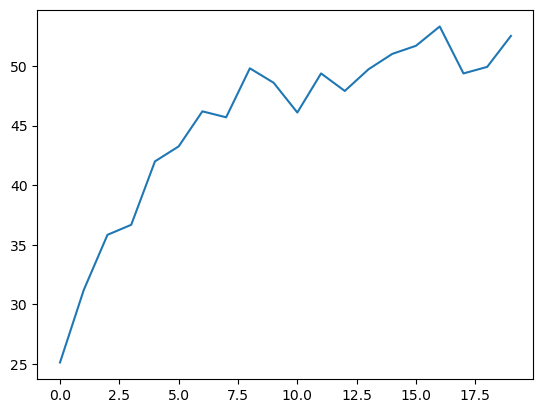

In [80]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Running on {device.type}.")

epochs = 20
lr = 0.1
lambda_reg = 0
batch_size = 64

train_loader, test_loader, num_classes = get_data_cifar10(batch_size=batch_size)

model = LeNet(num_classes=num_classes, n_channels=3, version='sigmoid_and_tanh')

model = model.to(device)

prefix = 'CIFAR10-SigTanh-e-{}-lr-{}'.format(epochs, lr)

best_model = train(model, train_loader, test_loader, batch_size, epochs, lr, prefix, device=device, save=True, debug=False, plot_histograms=False, lambda_reg=lambda_reg)


### CIFAR10 (RELU)

Training epochs...:   5%|▌         | 1/20 [00:13<04:20, 13.73s/it]

Saving Best Model with Accuracy: 40.8900
Epoch:   1 | Accuracy : 40.8900%


Training epochs...:  10%|█         | 2/20 [00:27<04:06, 13.71s/it]

Saving Best Model with Accuracy: 42.5700
Epoch:   2 | Accuracy : 42.5700%


Training epochs...:  15%|█▌        | 3/20 [00:41<03:54, 13.79s/it]

Saving Best Model with Accuracy: 50.3700
Epoch:   3 | Accuracy : 50.3700%


Training epochs...:  20%|██        | 4/20 [00:54<03:39, 13.73s/it]

Epoch:   4 | Accuracy : 47.6900%


Training epochs...:  25%|██▌       | 5/20 [01:08<03:26, 13.79s/it]

Saving Best Model with Accuracy: 55.2000
Epoch:   5 | Accuracy : 55.2000%


Training epochs...:  30%|███       | 6/20 [01:22<03:12, 13.76s/it]

Epoch:   6 | Accuracy : 54.7700%


Training epochs...:  35%|███▌      | 7/20 [01:36<02:58, 13.77s/it]

Saving Best Model with Accuracy: 56.9000
Epoch:   7 | Accuracy : 56.9000%


Training epochs...:  40%|████      | 8/20 [01:50<02:45, 13.75s/it]

Saving Best Model with Accuracy: 57.7100
Epoch:   8 | Accuracy : 57.7100%


Training epochs...:  45%|████▌     | 9/20 [02:03<02:31, 13.78s/it]

Saving Best Model with Accuracy: 57.8200
Epoch:   9 | Accuracy : 57.8200%


Training epochs...:  50%|█████     | 10/20 [02:17<02:17, 13.76s/it]

Epoch:  10 | Accuracy : 57.6500%


Training epochs...:  55%|█████▌    | 11/20 [02:31<02:03, 13.70s/it]

Epoch:  11 | Accuracy : 54.0500%


Training epochs...:  60%|██████    | 12/20 [02:44<01:49, 13.68s/it]

Saving Best Model with Accuracy: 59.8800
Epoch:  12 | Accuracy : 59.8800%


Training epochs...:  65%|██████▌   | 13/20 [02:58<01:35, 13.66s/it]

Epoch:  13 | Accuracy : 58.9700%


Training epochs...:  70%|███████   | 14/20 [03:12<01:21, 13.67s/it]

Saving Best Model with Accuracy: 61.1400
Epoch:  14 | Accuracy : 61.1400%


Training epochs...:  75%|███████▌  | 15/20 [03:25<01:08, 13.70s/it]

Epoch:  15 | Accuracy : 59.1300%


Training epochs...:  80%|████████  | 16/20 [03:39<00:54, 13.65s/it]

Epoch:  16 | Accuracy : 56.4800%


Training epochs...:  85%|████████▌ | 17/20 [03:53<00:40, 13.64s/it]

Epoch:  17 | Accuracy : 58.5600%


Training epochs...:  90%|█████████ | 18/20 [04:06<00:27, 13.63s/it]

Epoch:  18 | Accuracy : 57.8700%


Training epochs...:  95%|█████████▌| 19/20 [04:20<00:13, 13.61s/it]

Epoch:  19 | Accuracy : 60.2200%


Training epochs...: 100%|██████████| 20/20 [04:33<00:00, 13.69s/it]

Epoch:  20 | Accuracy : 59.2600%
Model saved in: ./LeNet5-CIFAR10-61.14.pkl


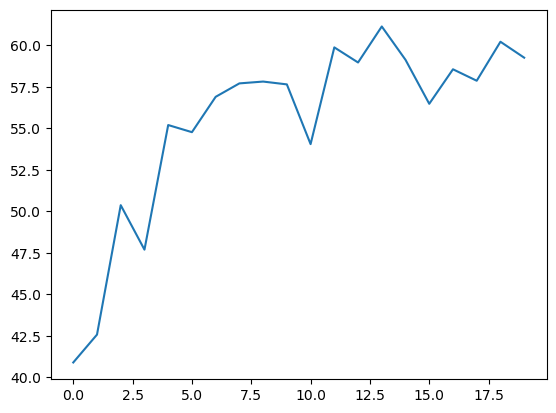

In [81]:
model = LeNet(num_classes=num_classes, n_channels=3, version='relu')

model = model.to(device)

prefix = 'CIFAR10-RELU-e-{}-lr-{}'.format(epochs, lr)

best_model = train(model, train_loader, test_loader, batch_size, epochs, lr, prefix, device=device, save=True, debug=False, plot_histograms=False, lambda_reg=lambda_reg)


## Prevendo amostra
Para a previsão de amostras serão utilizados somente os modelos de maior desempenho dos testes anteriores.
Sendo ambos utilizando ativação RELU.

In [ ]:
def sample_and_predict(net, test_loader, device, use_rgb=False):
    dataset = test_loader.dataset

    i = np.random.randint(len(dataset))
    sample, label = dataset[i]

    x = sample.float()

    if use_rgb and x.shape[0] == 1:
        x = x.expand(3, x.shape[1], x.shape[2])

    x = x.unsqueeze(0).to(device)

    y = net(x)
    probs = torch.softmax(y, dim=1)
    confidence, prediction = torch.max(probs, 1)

    print(f'Sample: {i}')
    plt.axis('off')
    if x.shape[1] == 1:
        plt.imshow(sample.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(sample.numpy(), (1, 2, 0)))

    confidence = confidence.item()
    prediction = prediction.item()

    return prediction, confidence, label


### MNIST

Sample: 4419

Predicted clas: Oito 
Classifier confidence: 99.99% 
True label: Oito


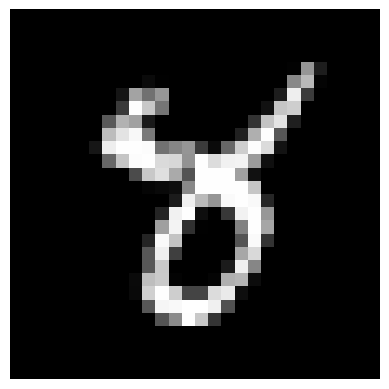

In [134]:
mnist_classes = {
    0: "Zero",
    1: "Um",
    2: "Dois",
    3: "Três",
    4: "Quatro",
    5: "Cinco",
    6: "Seis",
    7: "Sete",
    8: "Oito",
    9: "Nove"
}

def load_LeNet_mnist ( device , path, n_channels ) :
    net = LeNet(num_classes=10, n_channels=n_channels, version='relu')
    net = net.to(device)
    net.load_state_dict(torch.load(path))
    net.eval()
    return net

path = './MNIST-RELU-99.02.pkl'
n_channels = 1

_, test_loader, _ = get_data_mnist(batch_size)
lenet_mnist_relu = load_LeNet_mnist(device, path, n_channels)
prediction, confidence, label = sample_and_predict(lenet_mnist_relu, test_loader, device)

print( f'\nPredicted clas: {mnist_classes[prediction]} \nClassifier confidence: {confidence*100:4.2f}% \nTrue label: {mnist_classes[label]}' )

### CIFAR10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..1.0].


Sample: 1629

Predicted clas: Caminhão 
Classifier confidence: 98.20% 
True label: Caminhão


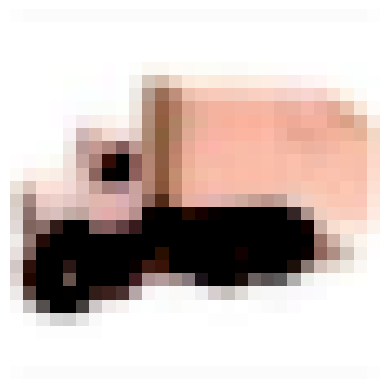

In [146]:
cifar10_classes = {
    0: "Avião",
    1: "Automóvel",
    2: "Pássaro",
    3: "Gato",
    4: "Veado",
    5: "Cachorro",
    6: "Sapo",
    7: "Cavalo",
    8: "Navio",
    9: "Caminhão"
}

def load_LeNet_cifar10 ( device , path, n_channels ) :
    net = LeNet(num_classes=10, n_channels=n_channels, version='relu')
    net = net.to(device)
    net.load_state_dict(torch.load(path))
    net.eval()
    return net

path = './CIFAR10-RELU-61.14.pkl'
n_channels = 3
_, test_loader, _ = get_data_cifar10(batch_size)

lenet_cifar_relu = load_LeNet_cifar10(device, path, n_channels)
prediction, confidence, label = sample_and_predict(lenet_cifar_relu, test_loader, device)

print( f'\nPredicted clas: {cifar10_classes[prediction]} \nClassifier confidence: {confidence*100:4.2f}% \nTrue label: {cifar10_classes[label]}' )

## Análise de Resultados

### MNIST
Analisando os modelos treinados para o critério de alcançar 98% de acurácia em teste, observamos que a combinação Sigmoid e Tanh atingiu esse patamar apenas na 11ª época, quando chegou a 98,11% de acurácia. Por outro lado, o modelo com ReLU superou 98% já na 3ª época, alcançando a acurácia de 98,26%. 

O treinamento com ReLU apresentou um progresso muito rápido desde o início, já na primeira época a acurácia estava em 95,14%, subindo para 97,47% na segunda e superando 98% na terceira época. Após esse ponto, a curva de aprendizado estabilizou-se, mantendo valores acima de 98% com oscilações mínimas, o que indica uma convergência eficiente e estável. Por outro lado, o treino com Sigmoid e Tanh mostrou um comportamento diferente. Na primeira época, a acurácia foi de apenas 10,28%, enquanto na segunda, houve um salto considerável até 87,24%. Além disso, depois de atingir valores elevados, a curva oscilou entre 96% e 98,5%, sinalizando maior instabilidade ao longo do processo.

Conclui-se que a ReLU demonstrou ser consideravelmente superior em eficiência de aprendizado e estabilidade, evitando problemas de gradiente saturado e convergindo rapidamente. Já o par Sigmoid e Tanh, embora capaz de atingir alta acurácia, precisou de muito mais épocas para treinar e apresentou maior variabilidade em seu desempenho.

### CIFAR10
O treinamento com ReLU mostrou uma evolução de acurácia muito mais rápida e consistente em comparação ao uso combinado de Sigmoid e Tanh. Logo na primeira época, o modelo com ReLU alcançou cerca de 40,89% de acurácia, subindo para 50,37% na terceira época e ultrapassando os 55% logo na quinta. A curva de aprendizado segue acelerada até a nona época, quando o desempenho se estabiliza em torno de 57%, com pequenas oscilações até bater o pico de 61,14% na décima quarta época.

Por outro lado, o par Sigmoid e Tanh partiu de apenas 25,12% na época inicial e progrediu de forma mais lenta, atingindo 35,83% na terceira época e somente 41,99% na quinta. A partir da nona época, observa-se um platô em torno de 46% a 50%, com flutuações que culminaram em uma acurácia máxima de 53,31% apenas na décima sétima época. 

Quando comparamos o número de épocas necessárias para chegar a 98% de acurácia, vemos que nenhum dos dois modelos alcançou sequer 62% dentro das 20 épocas treinadas, esse comportamento é compreensível visto que o CIFAR10 é um dataset mais desafiador e com mais classes. Portanto, para atingir patamares mais elevados, seria preciso estender o número de épocas e revisar hiperparâmetros. De todo modo, a ReLU permanece a opção preferível entre essas duas funções de ativação, graças à sua capacidade de acelerar a convergência e alcançar níveis de desempenho bem mais altos em menos épocas.
